In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib widget

In [2]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

from ripser import ripser
from persim import plot_diagrams

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from datahandling import Dataset, MESampler
from plotting_functions import scatter3d, set_size
from synthetic_grid_cells import *
from methods import *
from stats import *
import utils

/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/umap/distances.py:1086: NumbaD

In [3]:
def get_activities(model, inputs, r, bins, prune_mask = None):  
    if prune_mask is not None: # set prune mask
        model.prune_mask = prune_mask 
        
    act = model.g(inputs).detach().cpu().numpy() # run model
    ratemaps = utils.create_ratemaps(act.reshape(-1, act.shape[-1]), r.reshape(-1, 2), [bins,bins])
    ratemaps = np.array([fill_nan(ratemap, method='nearest') for ratemap in ratemaps])
    g = ratemaps.reshape(ratemaps.shape[0],-1).T
    return g    

def normalize_pointcloud(pointcloud):
    pointcloud = (pointcloud - np.mean(pointcloud, axis = 0, keepdims=True))
    pointcloud /= np.amax(pointcloud)
    return pointcloud

def plot_torus(umap_fit, pca_fit, figsize):
    pointcloud = normalize_pointcloud(umap_fit)
    fig, axs = scatter3d(pointcloud, pca_fit[:,0], azim_elev_title = False, s = 0.04, alpha = 0.5, edgecolor = None, figsize = figsize)

    for ax in np.ravel(axs):
        RADIUS = 0.675 # Control this value.
        ax.set_xlim3d(-RADIUS, RADIUS)
        ax.set_zlim3d(-RADIUS, RADIUS)
        ax.set_ylim3d(-RADIUS, RADIUS)
    return fig, axs

In [4]:
base_path = "../"

experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()

module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_all_clusters.npz")
clusters = [module_indices[f] for f in module_indices.files]
module_indices = np.array(list(clusters[2]) + list(clusters[12]) + list(clusters[15])) # band-like units


ncells = len(module_indices)

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [5]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)

datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
model = utils.load_model(experiment)

Loading model at epoch = 02999 ../data/emergent-grid-cells/gg-3ME/checkpoints/02999


### Low dimensional projection of all torus cells

In [8]:
env = 0 # just consider environment 0
bins = 64 # ratemap resolution for visualization; result is bins x bins
num_trajectories= 5000 # number of trajectories used to construct ratemaps

In [9]:
panesize = set_size(width=345, mode='square')
figsize = np.array((panesize[0]/3,panesize[1]/3))

ph_lims = [-0.05, 1.2, -0.05, 1.2] # limits of persistent homology, for comparing 
ph_figsize = (1, 1)
k = 1000
ns = 3000
metric = "cosine"

In [10]:
# just create trajectories once
inputs, r, v = utils.create_trajectories(dataset, env, num_trajectories = num_trajectories)

In [11]:
g = get_activities(model, inputs, r, bins)
g = g[...,module_indices]
g.shape

(4096, 604)

In [ ]:
figs = []
for n2exclude in [20, 50, 200]:
    # set baseline pruning mask; just exclude from PH and visualization
    keep_idxs = np.random.choice(range(g.shape[-1]), size=g.shape[-1]-n2exclude, replace=False)

    pca_fit, umap_fit = PCA_UMAP(g[:,keep_idxs], n_neighbors = 4000, metric = "euclidean", min_dist = 0.8)
    inds, _,_ = utils.downsample_pointcloud(pca_fit, k = k, num_sample = ns, metric = metric)
    fig,axs = plot_torus(umap_fit[inds], pca_fit[inds], figsize =figsize)
    figs.append(fig)
    
    # persistent homology
    fig = plt.figure(figsize = ph_figsize)
    dgms = ripser(pca_fit[inds], n_perm = 500,  maxdim=2, coeff=47, metric = metric)['dgms']
    plot_diagrams(dgms, colormap = "bioAI.mplstyle", size = 5, legend = False, xy_range = ph_lims)
    plt.xlabel(""); plt.ylabel("")
    fig.savefig(experiment.paths['experiment'] / f'plots/0-pruning-#cells-{n2exclude}-homology')

In [ ]:
#[fig.savefig(experiment.paths['experiment'] / f'plots/0-pruning-#cells-{n2exclude}') for fig, n2exclude in zip(figs, [20, 50, 200])]

### Low dimensional projection of torus after different levels of pruning

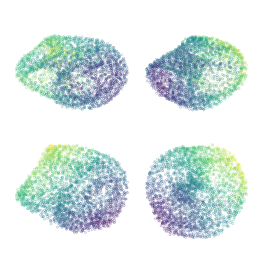

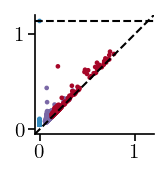

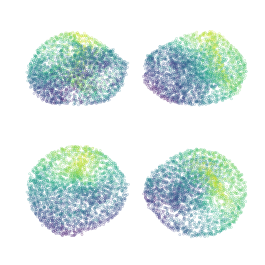

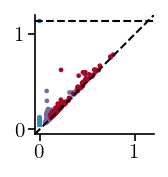

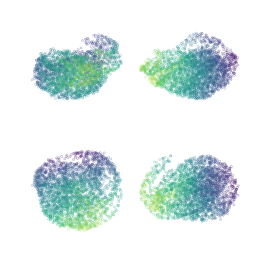

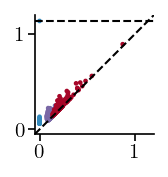

In [14]:
torus_figs = []
# torus pruning
for n2prune in [20, 50, 200]:
    ### set torus mask
    keep_idxs = np.random.choice(module_indices, size=ncells - n2prune, replace=False)
    # prune cells that are in module_indices, but not in keep_idxs
    prune_mask = list(set(module_indices) - set(keep_idxs))
    
    # get activations after pruning for visualizations
    g_pruned = get_activities(model, inputs, r, bins, prune_mask = prune_mask)
    g_pruned = g_pruned[...,keep_idxs]
    pca_fit, umap_fit = PCA_UMAP(g_pruned, n_neighbors = 4000, metric = "euclidean", min_dist = 0.8) # dimensionality reduction
    inds, _,_ = utils.downsample_pointcloud(pca_fit, k = k, num_sample = ns, metric = metric)
    fig,axs = plot_torus(umap_fit[inds], pca_fit[inds], figsize = figsize)
    torus_figs.append(fig)

    ### Do persistent homology
    dgms = ripser(pca_fit[inds], n_perm = 500,  maxdim=2, coeff=47, metric = metric)['dgms']
    fig = plt.figure(figsize = ph_figsize)
    plot_diagrams(dgms, colormap = "bioAI.mplstyle", size = 5, legend = False, xy_range = ph_lims)
    plt.xlabel(""); plt.ylabel("")
    fig.savefig(experiment.paths['experiment'] / f'plots/{n2prune}_cell-torus-pruning-ph')


In [ ]:
#[fig.savefig(experiment.paths['experiment'] / f'plots/torus-pruning-#cells-{n2prune}') for fig, n2prune in zip(torus_figs, [20, 50, 200])] 

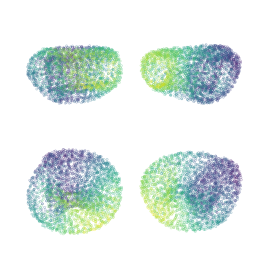

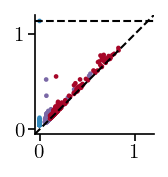

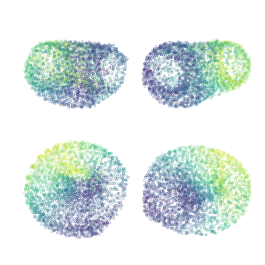

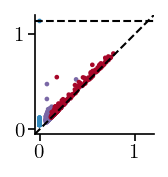

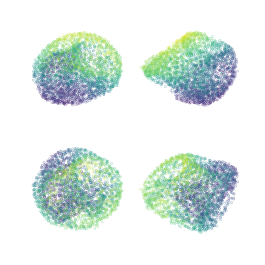

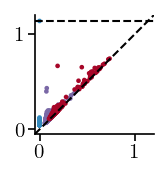

In [12]:
random_figs = []
# random pruning
for n2prune in [20, 50, 200]:
    keep_idxs = np.random.choice(model.Ng, size=model.Ng - n2prune, replace=False)
    prune_mask = list(set(np.arange(model.Ng)) - set(keep_idxs))
    g_pruned = get_activities(model, inputs, r, bins, prune_mask = prune_mask)
    
    # visualize using torus cells that haven't been pruned
    torus_idxs = list(set(keep_idxs).intersection(set(module_indices)))        
    g_pruned = g_pruned[..., torus_idxs]
    pca_fit, umap_fit = PCA_UMAP(g_pruned, n_neighbors = 4000, metric = "euclidean", min_dist = 0.8)
    inds, _,_ = utils.downsample_pointcloud(pca_fit, k = k, num_sample = ns, metric = metric)

    fig,axs = plot_torus(umap_fit[inds], pca_fit[inds], figsize = figsize)
    random_figs.append(fig)

    ### Do persistent homology
    dgms = ripser(pca_fit[inds], n_perm = 512,  maxdim=2, coeff=47, metric = metric)['dgms']
    fig = plt.figure(figsize = ph_figsize)
    plot_diagrams(dgms, colormap = "bioAI.mplstyle", size = 5, legend = False, xy_range = ph_lims)
    plt.xlabel(""); plt.ylabel("")
    fig.savefig(experiment.paths['experiment'] / f'plots/{n2prune}_cell-random-pruning-ph')

In [13]:
[fig.savefig(experiment.paths['experiment'] / f'plots/random-pruning-#cells-{n2prune}') for fig, n2prune in zip(random_figs, [20, 50, 200])]

[None, None, None]